# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pytree
print(f'pytree {pytree.__version__}')
print(f'pytree {pytree.__git_version__}')

remote_archive   = 'large_calibration/2/grenoble_2020-08-18_1944780.zip'
loopback_archive = 'large_calibration/2/grenoble_2020-08-18_1944779.zip'

threshold = 64000  # "semantic" breakpoint, found with another script

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

expected_loopback_bandwidth = 2e11/8
expected_loopback_latency = 1e-7

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name, exp_name=None):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'isend' : result['exp/exp_Isend.csv'],
        'recv'  : result['exp/exp_Recv.csv'],
        'wtime' : result['exp/exp_Wtime.csv'],
        'test'  : result['exp/exp_Test.csv'],
        'iprobe': result['exp/exp_Iprobe.csv'],
    }
    if exp_name is not None:
        for df in result.values():
            df['experiment'] = exp_name
    return result

pytree 0.0.6
pytree daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [2]:
remote   = load_experiment(remote_archive, exp_name='remote')
loopback = load_experiment(loopback_archive, exp_name='loopback')

### First visualization of the pingpong durations

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/pingpong_duration.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


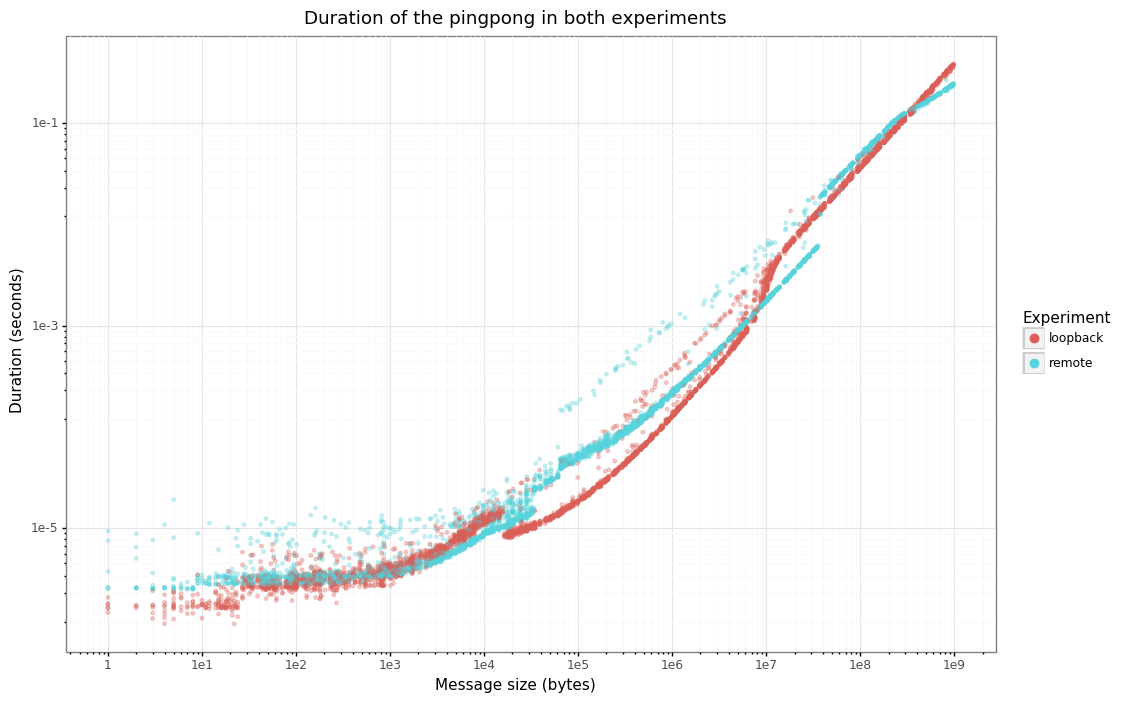

<ggplot: (-9223363303858391748)>

In [3]:
tmp = pandas.concat([remote['pingpong'], loopback['pingpong']])
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='duration', color='experiment')
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + scale_y_log10()
    + theme_bw()
    + ggtitle('Duration of the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Experiment')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
)
plot.save('/tmp/pingpong_duration.png')
plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/pingpong_bandwidth.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


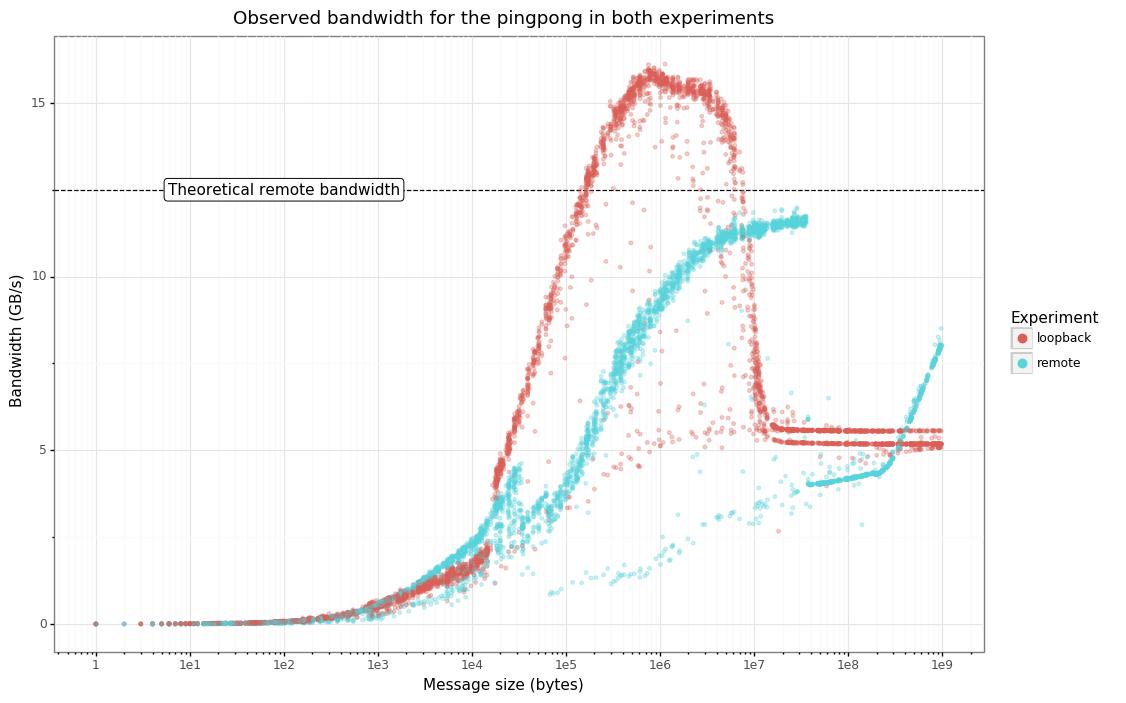

<ggplot: (-9223363303858251993)>

In [4]:
tmp['bandwidth'] = 2*tmp['msg_size'] / tmp['duration'] * 1e-9
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='bandwidth', color='experiment')
    + geom_hline(yintercept=expected_bandwidth*1e-9, linetype='dashed')
    + annotate('label', label='Theoretical remote bandwidth', x=100, y=expected_bandwidth*1e-9)
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + theme_bw()
    + ggtitle('Observed bandwidth for the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Bandwidth (GB/s)', color='Experiment')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
)
plot.save('/tmp/pingpong_bandwidth.png')
plot

298694745


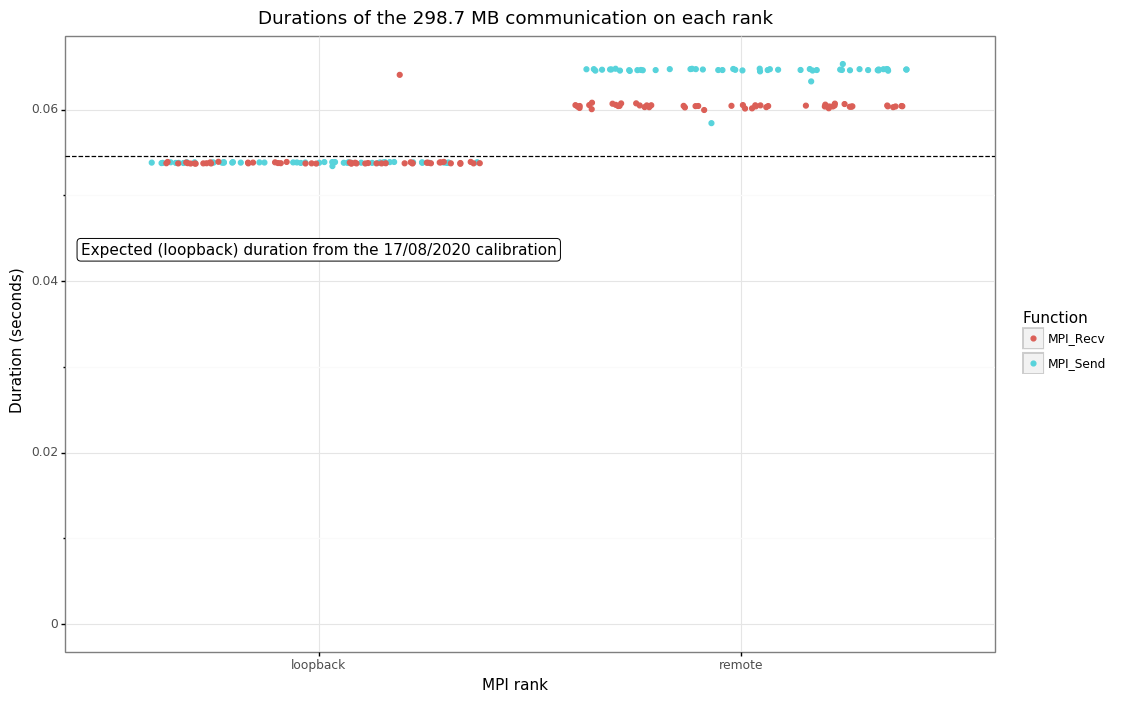

<ggplot: (-9223363303896421176)>

In [5]:
tmp = pandas.concat([loopback['send'], loopback['recv'], remote['send'], remote['recv']])
hpl_s = 2.56e8
size = tmp[(tmp['msg_size'] > hpl_s*0.7) & (tmp['msg_size'] < hpl_s*1.3)]['msg_size'].max()
print(size)

bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(tmp[tmp['msg_size'] == size])
    + aes(x='experiment', y='duration', color='op')
    + geom_jitter() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='MPI rank', y='Duration (seconds)', color='Function')
    + annotate('label', x=1, y=theoretical_duration*0.8, label='Expected (loopback) duration from the 17/08/2020 calibration')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB communication on each rank')
)

## Monitoring

In [6]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [7]:
dataframes = []
for mode, archive in [('remote', remote_archive), ('loopback', loopback_archive)]:
    monitoring = archive_extraction.read_monitoring(archive)
    monitoring['mode'] = mode
    dataframes.append(monitoring)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

703296


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,mode,date,real_start_time,cpu_id,in_exp,hostname
0,0.000000,dahu,4,1944780,1597747970,be197e25a861bd881c18604bbfccd774b286451926b875...,3.428906,0,0,frequency,37.192516,3596.169409,remote,2020-08-18 10:52:50,1.597755e+09,4:0,False,dahu-4
1,1.008564,dahu,4,1944780,1597747970,be197e25a861bd881c18604bbfccd774b286451926b875...,3.050024,0,0,frequency,37.192516,3596.169409,remote,2020-08-18 10:52:50,1.597755e+09,4:0,False,dahu-4
2,2.017103,dahu,4,1944780,1597747970,be197e25a861bd881c18604bbfccd774b286451926b875...,1.133825,0,0,frequency,37.192516,3596.169409,remote,2020-08-18 10:52:50,1.597755e+09,4:0,False,dahu-4
3,3.025284,dahu,4,1944780,1597747970,be197e25a861bd881c18604bbfccd774b286451926b875...,1.000012,0,0,frequency,37.192516,3596.169409,remote,2020-08-18 10:52:50,1.597755e+09,4:0,False,dahu-4
4,4.033452,dahu,4,1944780,1597747970,be197e25a861bd881c18604bbfccd774b286451926b875...,1.000012,0,0,frequency,37.192516,3596.169409,remote,2020-08-18 10:52:50,1.597755e+09,4:0,False,dahu-4


In [8]:
monitoring[monitoring.in_exp].groupby(['mode', 'hostname', 'cpu', 'kind'])[['value']].mean()

value
mode     hostname cpu kind                  
loopback dahu-32  0   frequency     1.956196
                      temperature  65.817643
                  1   frequency     1.956201
                      temperature  55.206890
remote   dahu-31  0   frequency     1.956986
                      temperature  68.875861
                  1   frequency     1.956195
                      temperature  56.761504
         dahu-4   0   frequency     1.956391
                      temperature  67.051441
                  1   frequency     1.956192
                      temperature  56.462771

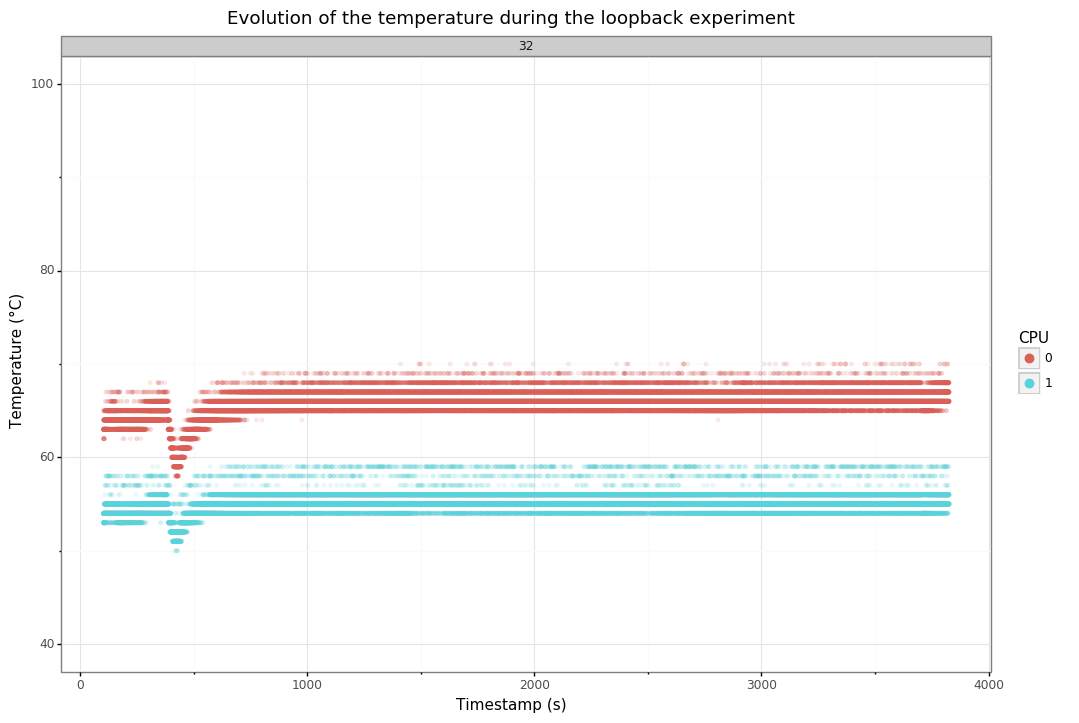

<ggplot: (-9223363303896553328)>


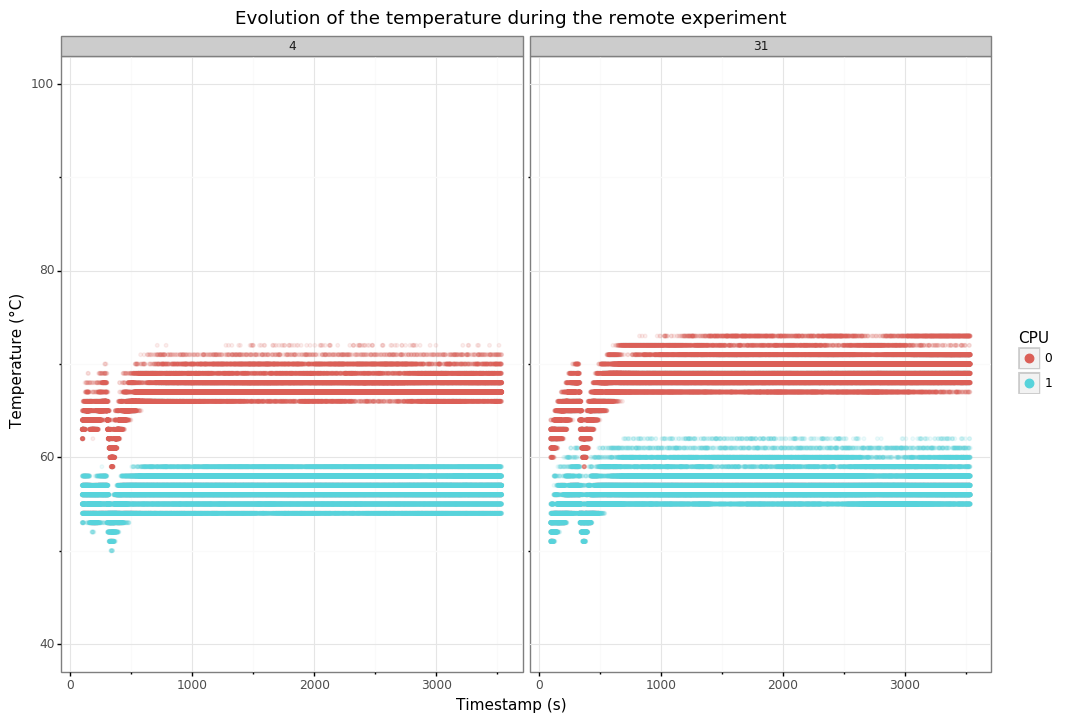

<ggplot: (-9223363303913323439)>


In [9]:
for mode in sorted(monitoring['mode'].unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring['mode'] == mode) & (monitoring.kind == 'temperature')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Temperature (°C)', color='CPU')
        + facet_wrap('node')
        + ggtitle(f'Evolution of the temperature during the {mode} experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[40, 100])
    )

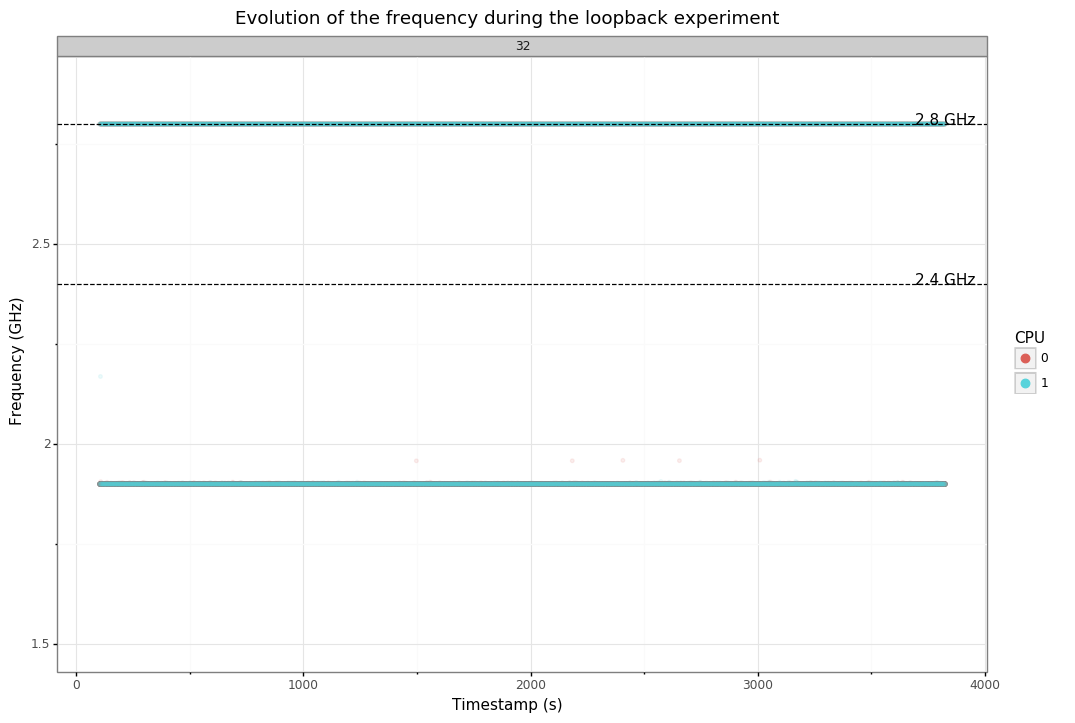

<ggplot: (8732940094177)>


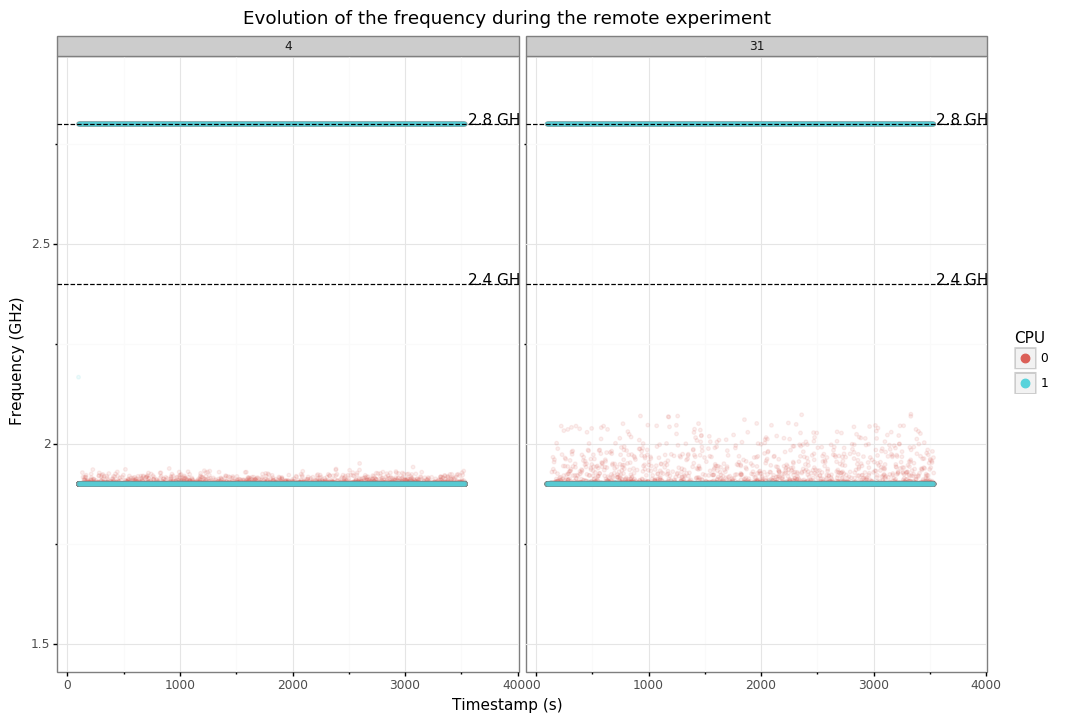

<ggplot: (8732937480000)>


In [10]:
for mode in sorted(monitoring['mode'].unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring['mode'] == mode) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
        + facet_wrap('node')
        + ggtitle(f'Evolution of the frequency during the {mode} experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.41)
        + geom_hline(yintercept=2.8, linetype='dashed')
        + annotate('text', label='2.8 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.81)
        + expand_limits(y=[1.5, 2.9])
    )